#### Estimate the age of a person from the image. Оценить возраст человека по изображению. 
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 

#### Exploratory and preprocessing data

Cоздать датафрейм содержащий относительный путь к изображению и целевую метку, который потом использовать при обучении.


Create a dataframe containing the relative path to the image and the target label, which is then used in training.

In [2]:
import os
import sys
import wget
import shutil
import tarfile

import re
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')

DATA_URL = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'
DATA_FILE = 'wiki_crop.tar'
DATA_FOLDER = 'wiki_crop'

print('OpenCV version ' + cv2.__version__)

OpenCV version 4.8.0


Загрузим файл с данными по ссылке (если файл не найден на диске)

In [2]:
def bar_custom(current, total, width=80):
    progress_msg = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write('\r' + progress_msg)
    sys.stdout.flush()

if not os.path.exists(DATA_FILE):
    wget.download(DATA_URL, DATA_FILE, bar=bar_custom)

Распакуем архив с набором данных в текущий каталог,
если каталог с данными еще не существует.

In [3]:
if not os.path.exists(DATA_FOLDER):
    tar = tarfile.open(DATA_FILE, 'r')
    tar.extractall()
    tar.close()

Выполним загрузку, проверку и обработку набора изображений из файлов

In [4]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Набор обработаных изображений для оценки возраста
cropped_images = pd.DataFrame(columns=['file_path', 'label'])

# Удалить каталог со старыми обработанными изображеним если существует, если нет - создать
if os.path.exists(os.path.join(DATA_FOLDER, 'cropped')):
    shutil.rmtree(os.path.join(DATA_FOLDER, 'cropped'), ignore_errors=True)

os.makedirs(os.path.join(DATA_FOLDER, 'cropped'))

IMG_SIZE = 64

img_valid=0 #счетчик всех корректных изображений
img_misloaded=0 #счетчик изображений с ошибками при загрузке
img_too_small=0 #счетчик изображений некорректного размера (1х1)
img_bad_faces=0 #счетчик изображений без лиц
img_bad_label=0 #счетчик изображений с некорретной оценкой класса

# Перебор всех вложенных элементов в указаном каталоге
for dir in tqdm(os.listdir(DATA_FOLDER)):
    # если вложенный элемент - каталог
    if os.path.isdir(os.path.join(DATA_FOLDER, dir)):
        # Перебор всех файлов в каталоге
        for file in os.listdir(os.path.join(DATA_FOLDER, dir)):
            try:
                source_file_path = os.path.join(DATA_FOLDER, dir, file)

                # загрузить изображение
                img = Image.open(source_file_path)
                img_array = np.array(img)

                # получить параметры изображения
                h, w = img_array.shape[:2]

                # если размер изображения меньше заданного - пропускаем
                if w < 128:
                    img_too_small+=1 
                    continue

                # выполняем детекцию лиц с максимально строгими настройками и минимальным размером лица 64х64
                face_rects1 = face_detector.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=6, minSize=(64,64))

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(face_rects1) != 1:
                    img_bad_faces+=1
                    continue  

               
    
                # формируем целевую метку изображения, как разность между вторым и первым годами в наименовании файла
                year_matched = re.findall(r'_(\d{4})', file)
                try:
                    label = int(year_matched[1]) - int(year_matched[0])
                except:
                    label = -1 
                
                # оставляем только изображения к меткой из заданного диапазона
                if (label < 1) | (label > 100):
                    img_bad_label+=1
                    continue

                # выполняем обрезку изображения по контуру лица и приведение к требуемому размеру
                x,y,h,w = face_rects1[0]
                img = img.crop((x, y, x+w, y+h)).resize((IMG_SIZE,IMG_SIZE), resample=Image.Resampling.BILINEAR)    

                # сохраняем обрезанное изображение в файл
                cropped_file_path = os.path.join(DATA_FOLDER, 'cropped', file)
                cropped_images = pd.concat([cropped_images, pd.DataFrame([{'file_path': cropped_file_path, 'label': label}])], ignore_index=True)
                img.save(cropped_file_path)
                
                
            except Exception as ex:
                img_misloaded+=1
                None # Если файл не удается прочитать - пропускаем его

print(f'Изображений с ошибками при загрузке {img_misloaded}')
print(f'Изображений с некорректными размерами {img_too_small}')
print(f'Изображений на которых не найдены лица {img_bad_faces}')
print(f'Изображений c некорректной меткой класса {img_bad_label}')

print(f'Всего корректных изображений {cropped_images.shape[0]}')

# Сохранить результат обработки данных в CSV-файл
cropped_images.to_csv('imdb_crops_2.csv')

100%|██████████| 102/102 [02:08<00:00,  1.26s/it]

Изображений с ошибками при загрузке 0
Изображений с некорректными размерами 34599
Изображений на которых не найдены лица 23185
Изображений c некорректной меткой класса 24
Всего корректных изображений 22593


In [5]:
cropped_images = pd.read_csv('imdb_crops_2.csv')
cropped_images.drop(['Unnamed: 0'], axis=1, inplace=True)
cropped_images.head(3)

,file_path,label
0,wiki_crop/cropped/2399661_1977-09-02_2008.jpg,31
1,wiki_crop/cropped/44438061_1937-11-14_1969.jpg,32
2,wiki_crop/cropped/37699961_1890-12-11_1947.jpg,57


Отобразим произвольные 50 файлов изображений из набора обработанных данных. 

Display arbitrary 50 image files from the processed dataset.

<Axes: >

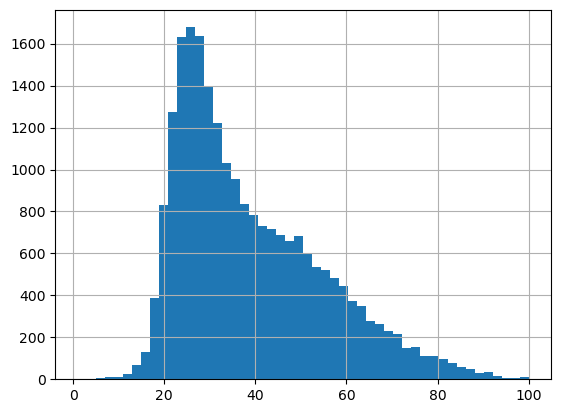

In [6]:
cropped_images['label'].hist(bins=50)

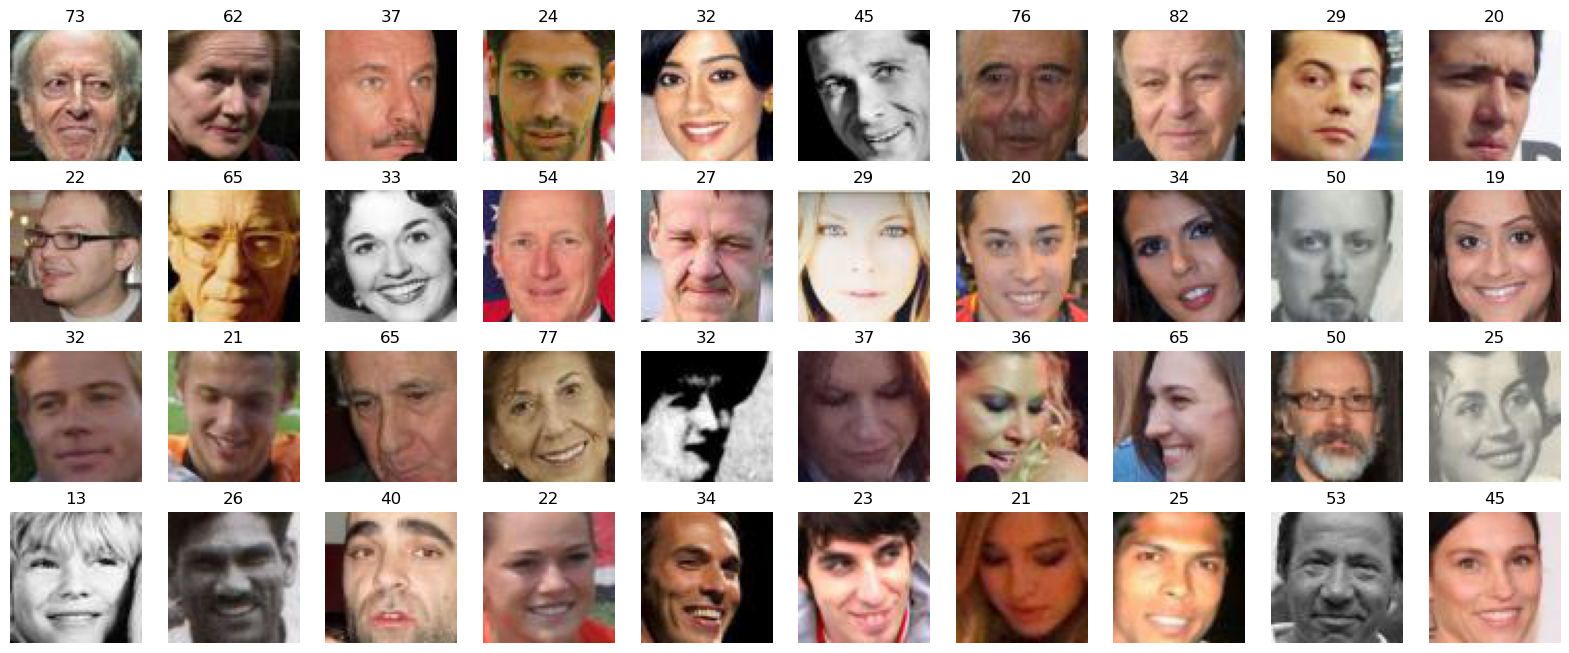

In [7]:
df = cropped_images
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
    for j in range(10):
        idx = np.random.choice(range(df.shape[0]))
        file, label = df.iloc[idx].file_path, df.iloc[idx].label
        ax[i, j].imshow(plt.imread(file), cmap='gray')
        ax[i, j].set_title(label)
        ax[i, j].axis('off')

---

#### Split the data using ImageDataGenerator

Разобьем данные на train, validation, test с помощью ImageDataGenerator. 

Split the data into train, validation, test using ImageDataGenerator

In [7]:
cropped_images['label'] = cropped_images['label'].astype(np.int32)

In [8]:
train, test = train_test_split(cropped_images, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [10]:
TARGET_SIZE = (64,64)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="file_path",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)



Found 12652 validated image filenames.
Found 5422 validated image filenames.
Found 4519 validated image filenames.


----------------

#### Model selection and training

Создадим три модели регрессии и обучим их. 

Create three regression models and fit them.

In [15]:
#1
# Создание модели
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation='linear')(x)  # Линейная активация для регрессии
model = keras.Model(inputs=base_model.input, outputs=x)

# Компиляция модели
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])

# Обучение модели
history = model.fit_generator(train_generator, epochs=7, validation_data= valid_generator)

Epoch 1/7
396/396 [==============================] - 199s 498ms/step - loss: 174.9678 - accuracy: 7.9039e-05 - val_loss: 353.5177 - val_accuracy: 1.8443e-04
Epoch 2/7
396/396 [==============================] - 220s 557ms/step - loss: 115.2186 - accuracy: 7.9039e-05 - val_loss: 208.4758 - val_accuracy: 1.8443e-04
Epoch 3/7
396/396 [==============================] - 885s 2s/step - loss: 96.2219 - accuracy: 7.9039e-05 - val_loss: 138.7851 - val_accuracy: 1.8443e-04
Epoch 4/7
396/396 [==============================] - 1767s 4s/step - loss: 83.5757 - accuracy: 7.9039e-05 - val_loss: 128.6781 - val_accuracy: 1.8443e-04
Epoch 5/7
396/396 [==============================] - 186s 470ms/step - loss: 69.5880 - accuracy: 7.9039e-05 - val_loss: 128.2762 - val_accuracy: 1.8443e-04
Epoch 6/7
396/396 [==============================] - 1475s 4s/step - loss: 57.4225 - accuracy: 7.9039e-05 - val_loss: 147.8824 - val_accuracy: 1.8443e-04
Epoch 7/7
396/396 [==============================] - 5777s 15s/step -

<Axes: >

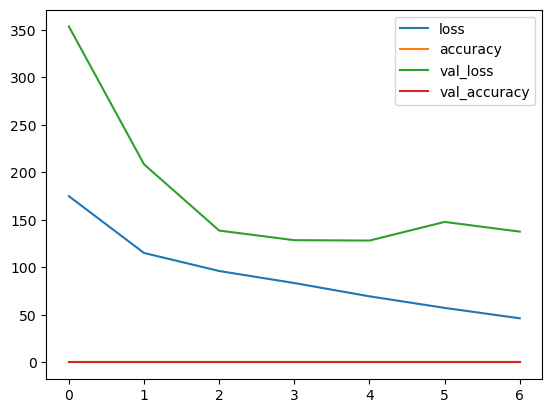

In [16]:
pd.DataFrame(history.history).plot()

In [17]:
#2
# Создание модели
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(1, activation='linear')(x)  # Линейная активация для регрессии
model = keras.Model(inputs=base_model.input, outputs=x)

# Компиляция модели
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])

# Обучение модели
history = model.fit_generator(train_generator, epochs=7, validation_data= valid_generator)

Epoch 1/7
396/396 [==============================] - 464s 1s/step - loss: 1288.0652 - accuracy: 7.9039e-05 - val_loss: 242.7979 - val_accuracy: 1.8443e-04
Epoch 2/7
396/396 [==============================] - 514s 1s/step - loss: 246.0595 - accuracy: 7.9039e-05 - val_loss: 278.1510 - val_accuracy: 1.8443e-04
Epoch 3/7
396/396 [==============================] - 502s 1s/step - loss: 229.2833 - accuracy: 7.9039e-05 - val_loss: 195.8617 - val_accuracy: 1.8443e-04
Epoch 4/7
396/396 [==============================] - 538s 1s/step - loss: 198.4196 - accuracy: 7.9039e-05 - val_loss: 193.2059 - val_accuracy: 1.8443e-04
Epoch 5/7
396/396 [==============================] - 945s 2s/step - loss: 173.4081 - accuracy: 7.9039e-05 - val_loss: 183.0925 - val_accuracy: 1.8443e-04
Epoch 6/7
396/396 [==============================] - 574s 1s/step - loss: 159.3223 - accuracy: 7.9039e-05 - val_loss: 211.6282 - val_accuracy: 1.8443e-04
Epoch 7/7
396/396 [==============================] - 667s 2s/step - loss: 1

<Axes: >

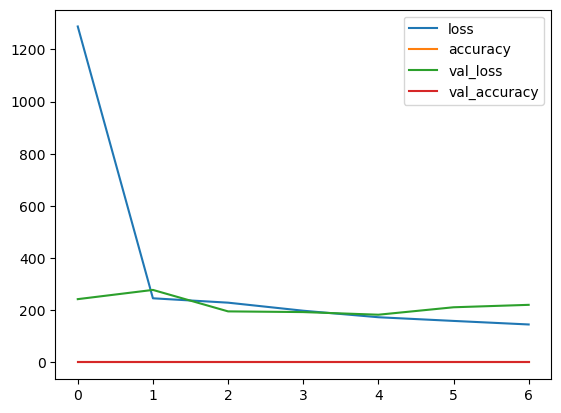

In [18]:
pd.DataFrame(history.history).plot()

In [23]:
#3

# Создание модели
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Регрессионный выход
])

# Компиляция модели
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])

# Обучение модели
history = model.fit_generator(train_generator, epochs=7, validation_data= valid_generator)

Epoch 1/7
396/396 [==============================] - 11s 28ms/step - loss: 277.4870 - accuracy: 7.9039e-05 - val_loss: 293.9986 - val_accuracy: 1.8443e-04
Epoch 2/7
396/396 [==============================] - 11s 28ms/step - loss: 209.9776 - accuracy: 7.9039e-05 - val_loss: 200.4311 - val_accuracy: 1.8443e-04
Epoch 3/7
396/396 [==============================] - 11s 28ms/step - loss: 191.2965 - accuracy: 7.9039e-05 - val_loss: 231.4432 - val_accuracy: 1.8443e-04
Epoch 4/7
396/396 [==============================] - 11s 29ms/step - loss: 177.3288 - accuracy: 7.9039e-05 - val_loss: 179.5076 - val_accuracy: 1.8443e-04
Epoch 5/7
396/396 [==============================] - 11s 29ms/step - loss: 164.5674 - accuracy: 7.9039e-05 - val_loss: 170.1803 - val_accuracy: 1.8443e-04
Epoch 6/7
396/396 [==============================] - 11s 28ms/step - loss: 152.4488 - accuracy: 7.9039e-05 - val_loss: 154.9565 - val_accuracy: 1.8443e-04
Epoch 7/7
396/396 [==============================] - 11s 28ms/step - l

<Axes: >

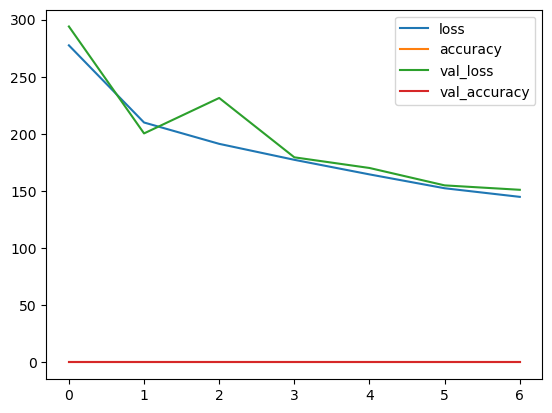

In [24]:
pd.DataFrame(history.history).plot()

#### Conclusions

After processing the data and selecting from the pictures only those that were with faces of the required size 64/64, and the correct class label. I trained three models: two pre-trained models ResNet50 and VGG16 showed better results than the created neural model. However, the graphs show that the accuracy does not increase and the error on the validation set does not coincide with the test one. Option to fix: convert the photo to monochrome - this was not done because the pre-trained models did not work on input_shape=(64,64,1).

Обработав данные и выделив из картинок только те что были с лицами, нужного размера 64/64, и корректной меткой класса. Я обучила три модели: две предобученные модели ResNet50 и VGG16 показали лучше результат чем созданная нейронная модель. Однако по графикам видно, что не растет точность и ошибка на валидационной выборке не совпадает с тестовой. Вариант исправления: перевести фото в монохром - это не было сделано так как предобученные модели не работали на input_shape=(64,64,1).